# Generate state vector netcdf file from shape file

Based on https://www.guillaumedueymes.com/post/shapefile_netcdf/ and https://regionmask.readthedocs.io/en/v0.8.0/notebooks/geopandas.html?highlight=shape%20file

In [36]:
import xarray as xr 
import numpy as np
import regionmask
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
from sklearn.cluster import KMeans
import colorcet as cc
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings(action='ignore')
%matplotlib inline

In [2]:
# Open shape file with geopandas
shapefile_path = './PermianBasin_Extent_201712.shp'
shape = gpd.read_file(shapefile_path)
shape

,geometry
0,"POLYGON ((-100.54152 33.84438, -100.50482 33.6..."


In [20]:
# Convert shape to mask with regionmask
lat = np.arange(       24,     39+.25, 0.025)
lon = np.arange(-110.9375, -95+0.3125, 0.03125)
mask = regionmask.mask_geopandas(shape, lon, lat) + 1
mask

<xarray.DataArray 'region' (lat: 610, lon: 520)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 24.0 24.02 24.05 24.07 ... 39.15 39.17 39.2 39.22
  * lon      (lon) float64 -110.9 -110.9 -110.9 -110.8 ... -94.78 -94.75 -94.72

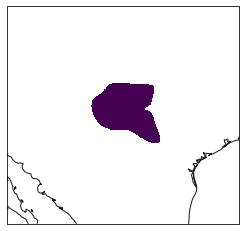

In [21]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
mask.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ax.coastlines(color="0.1");

In [22]:
# Define grid of state vector file

# Grid lats and lons
lat = np.arange(       24,     39+.25, 0.25  )      # [  24.0000,  39]
lon = np.arange(-110.9375, -95+0.3125, 0.3125)      # [-110.9375, -95]

# Make array of zeros to store clusters
n_lat = len(lat)
n_lon = len(lon)
state_vector = np.zeros((n_lat,n_lon))
state_vector.shape

(61, 52)

In [23]:
def nearest_loc(loc_query, loc_grid, tolerance=0.5):
    """ Find the index of the nearest grid location to a query location, with some tolerance. """

    distances = np.abs(loc_grid - loc_query)
    ind = distances.argmin()
    if distances[ind] >= tolerance:
        return np.nan
    else:
        return ind

In [24]:
for i in range(n_lat):
    for j in range(n_lon):
        x_ind = nearest_loc(lon[j], mask['lon'])
        y_ind = nearest_loc(lat[i], mask['lat'])
        if mask[y_ind,x_ind] == 1:
            state_vector[i,j] = 1

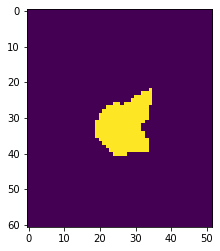

In [25]:
plt.imshow(state_vector)

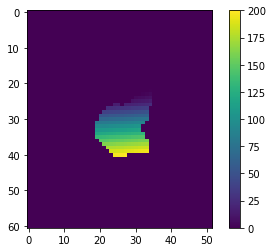

In [26]:
# Enumerate values
count = 1
for r in range(n_lat):
    for c in range(n_lon):
        if state_vector[r,c] == 1:
            state_vector[r,c] = count
            count += 1
            
plt.imshow(state_vector)
colors = plt.colorbar()
plt.show()

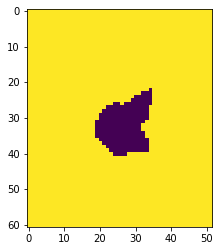

In [27]:
# Buffer elements
buffer_elements = np.abs((state_vector > 0) - 1)
plt.imshow(buffer_elements)
plt.show()

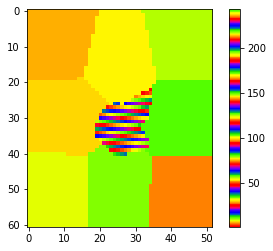

In [29]:
# Image coordinates
irows = np.arange(buffer_elements.shape[0])
icols = np.arange(buffer_elements.shape[1])
irows = np.transpose(np.tile(irows,(len(icols),1)))
icols = np.tile(icols,(len(irows),1)) * (buffer_elements > 0)

irows_good = irows[buffer_elements > 0]
icols_good = icols[buffer_elements > 0]

coords = [[icols_good[j], irows_good[j]] for j in range(len(irows_good))]

# Kmeans based on image coordinates
nbuffelements = 8
X = np.array(coords)
kmeans = KMeans(n_clusters=nbuffelements, random_state=0).fit(X)

# Assign labels
for r in range(n_lat):
    for c in range(n_lon):
        if state_vector[r,c] == 0:
            state_vector[r,c] = kmeans.predict([[c,r]]) + 235 + 1

plt.imshow(state_vector, cmap='prism')
colors = plt.colorbar()
plt.show()

In [30]:
# Convert to data array
state_vector_arr = xr.DataArray(state_vector, [("lat", list(lat)), ("lon", list(lon))], attrs={'units': "none"})
state_vector_arr

<xarray.DataArray (lat: 61, lon: 52)>
array([[237., 237., 237., ..., 241., 241., 241.],
       [237., 237., 237., ..., 241., 241., 241.],
       [237., 237., 237., ..., 241., 241., 241.],
       ...,
       [240., 240., 240., ..., 236., 236., 236.],
       [240., 240., 240., ..., 236., 236., 236.],
       [240., 240., 240., ..., 236., 236., 236.]])
Coordinates:
  * lat      (lat) float64 24.0 24.25 24.5 24.75 25.0 ... 38.25 38.5 38.75 39.0
  * lon      (lon) float64 -110.9 -110.6 -110.3 -110.0 ... -95.62 -95.31 -95.0
Attributes:
    units:    none

In [31]:
# Create dataset
ds_state_vector = xr.Dataset(
                {
                    "state_vector": (["lat", "lon"], state_vector_arr),
                },
                coords={
                    "lon": ("lon", lon),
                    "lat": ("lat", lat),
                },
                
                )
ds_state_vector

<xarray.Dataset>
Dimensions:       (lat: 61, lon: 52)
Coordinates:
  * lon           (lon) float64 -110.9 -110.6 -110.3 ... -95.62 -95.31 -95.0
  * lat           (lat) float64 24.0 24.25 24.5 24.75 ... 38.25 38.5 38.75 39.0
Data variables:
    state_vector  (lat, lon) float64 237.0 237.0 237.0 ... 236.0 236.0 236.0

In [32]:
# Add attribue metadata
ds_state_vector.lat.attrs['units'] = 'degrees_north'
ds_state_vector.lat.attrs['long_name'] = 'Latitude'
ds_state_vector.lon.attrs['units'] = 'degrees_east'
ds_state_vector.lon.attrs['long_name'] = 'Longitude'
ds_state_vector.state_vector.attrs['units'] = 'none'
ds_state_vector

<xarray.Dataset>
Dimensions:       (lat: 61, lon: 52)
Coordinates:
  * lon           (lon) float64 -110.9 -110.6 -110.3 ... -95.62 -95.31 -95.0
  * lat           (lat) float64 24.0 24.25 24.5 24.75 ... 38.25 38.5 38.75 39.0
Data variables:
    state_vector  (lat, lon) float64 237.0 237.0 237.0 ... 236.0 236.0 236.0

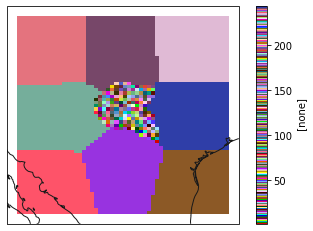

In [37]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
state_vector_arr.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cc.cm.glasbey,
    add_colorbar=True,
)
ax.coastlines(color="0.1");

In [ ]:
save_pth = './state_vector_permian_kmeans.nc'
ds_state_vector.to_netcdf(save_pth)